<a href="https://colab.research.google.com/github/Namsik-Yoon/pytorch_basic/blob/master/11.%20%EB%8B%A4%EB%8C%80%EC%9D%BC%20RNN%EC%9D%84%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20%ED%85%8D%EC%8A%A4%ED%8A%B8%20%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11. 다대일 RNN을 이용한 텍스트 분류

이번 챕터에서는 다대일 RNN을 이용하여 텍스트 분류를 해보겠습니다.

## 11.1 파이토치를 이용한 텍스트 분류(Text classification using PyTorch)

이번 챕터에서는 파이토치(PyTorch)로 인공 신경망을 이용한 텍스트 분류를 실습합니다. 실습에 앞서 딥 러닝을 이용해서 텍스트 분류가 수행될 때, 어떤 작업과 구성으로 진행되는지 간단히 미리 정리해보겠습니다.

### 11.1.1 훈련 데이터에 대한 이해

앞으로 배우게 될 텍스트 분류 작업은 지도 학습(Supervised Learning)에 속합니다. 지도 학습의 훈련 데이터는 레이블이라는 이름의 미리 정답이 적혀있는 데이터로 구성되어 있습니다. 쉽게 비유하면, 기계는 정답이 적혀져 있는 문제지를 열심히 공부하고, 향후에 정답이 없는 문제에 대해서도 정답을 예측해서 대답하게 되는 메커니즘입니다.

예를 들어 스팸 메일 분류기의 훈련 데이터같은 경우에는 메일의 내용과 해당 메일이 정상 메일인지, 스팸 메일인지 적혀있는 레이블로 구성되어져 있습니다. 아래와 같은 형식의 메일 샘플이 약 20,000개 있다고 가정해봅시다.

|텍스트(메일의 내용)|레이블(스팸 여부)|
|---|---|
|당신에게 드리는 마지막 혜택!...|스팸 메일|
|내일 뵐 수 있을지 확인 부탁...|정상 메일|
|쉿! 혼자보세요...|스팸 메일|
|...|...|
|(광고) 멋있어질 수 있는...|스팸 메일|

20,000개의 메일 샘플을 가진 이 데이터는 메일의 내용을 담고 있는 텍스트 데이터와 이 데이터가 스팸 메일인지 아닌지가 적혀있는 레이블. 두 가지 열로 이루어져있습니다. 기계는 이 20,000개의 메일 샘플 데이터를 학습하게 되는데, 만약 데이터가 깔끔하고 모델 또한 잘 설계되어져 있다면 학습이 다 된 이 모델은 훈련 데이터에서는 없었던 어떤 메일 텍스트가 주어졌을 때 레이블을 예측하게 됩니다.


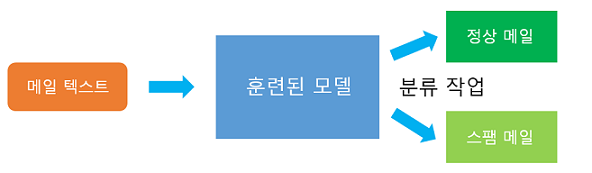

### 11.1.2 훈련 데이터와 테스트 데이터

위에서는 20,000개의 메일 샘플을 전부 훈련에 사용한다고 했지만 사실 갖고있는 전체 데이터를 전부 훈련에 사용하는 것 보다는 테스트용으로 일부는 남겨놓는 것으로 바람직합니다. 예를 들어서 20,000개의 샘플 중에서 18,000개의 샘플은 훈련용으로 사용하고, 2,000개의 샘플은 테스트용으로 보류한 채 훈련을 시킬 때는 사용하지 않을 수 있습니다. 그리고 나서 18,000개의 샘플로 모델이 훈련이 다 되면, 이제 보류해두었던 2,000개의 테스트용 샘플에서 레이블은 보여주지않고 모델에게 맞춰보라고 요구한 뒤, 정확도를 확인해볼 수 있습니다. 2,000개의 샘플에도 레이블이 있으므로 모델이 실제로 정답을 얼마나 맞추는지 정답률을 계산하게 됩니다.

뒤에 나오게 될 예제에서는 갖고 있는 데이터에서 분류하고자 하는 텍스트 데이터의 열을 X, 레이블 데이터의 열을 y라고 명명합니다. 그리고 이를 훈련 데이터(X_train, y_train)와 테스트 데이터(X_test, y_test)로 분리합니다. 모델은 X_train과 y_train을 학습하고, X_test에 대해서 레이블을 예측하게 됩니다. 그리고 모델이 예측한 레이블과 y_test를 비교해서 정답률을 계산하게 됩니다.

### 11.1.3 단어에 대한 인덱스 부여

앞서 워드 임베딩 챕터에서 단어를 밀집 벡터(dense vector)로 바꾸는 워드 임베딩에 대해서 배운 바 있습니다. 8챕터와 9챕터에서 설명하였지만, 파이토치(PyTorch)의 nn.Embedding()은 단어 각각에 대해 정수가 맵핑된 입력에 대해서 임베딩 작업을 수행할 수 있게 해줍니다.

단어 각각에 숫자 맵핑, 인덱스를 부여하는 방법으로는 2챕터의 정수 인코딩 챕터에서와 같이 단어를 빈도수 순대로 정렬하고 순차적으로 인덱스를 부여하는 방법이 있습니다. 로이터 뉴스 분류하기와 IMDB 리뷰 감성 분류하기 챕터에서도 이 방법을 사용하였으며, 해당 챕터에서 사용할 데이터들은 이미 이 작업이 끝난 상태입니다.

등장 빈도순대로 단어를 정렬하여 인덱스를 부여하였을 때의 장점은 등장 빈도수가 적은 단어의 제거입니다. 예를 들어서 25,000개의 단어가 있다고 가정하고, 해당 단어를 등장 빈도수 순가 높은 순서로 1부터 25,000까지 인덱스를 부여했다고 해보겠습니다. 이렇게 되면 등장 빈도수 순대로 등수가 부여된 것과 다름없기 때문에 전처리 작업에서 1,000을 넘는 인덱스를 가진 단어들을 제거시켜버리면 등장 빈도수 상위 1,000개의 단어만 남길 수 있습니다.

### 11.1.4 RNN으로 분류하기

```
# 실제 RNN 은닉층을 추가하는 코드.
nn.RNN(input_size, hidden_size, batch_first=True)
```

텍스트 분류 관점에서 앞서 배운 RNN 코드의 timesteps와 input_dim, 그리고 hidden_size를 해석해보면 다음과 같습니다. (위의 코드에서는 바닐라 RNN을 사용했지만, RNN의 변형인 LSTM이나 GRU도 아래의 사항은 동일합니다.)

hidden_size = 출력의 크기(output_dim).
timesteps = 시점의 수 = 각 문서에서의 단어 수.
input_size = 입력의 크기 = 각 단어의 벡터 표현의 차원 수.

### 11.1.5 RNN의 다-대-일(Many-to-One) 문제

텍스트 분류는 RNN의 다-대-일(Many-to-One) 문제에 속합니다. 즉, 텍스트 분류는 모든 시점(time step)에 대해서 입력을 받지만 최종 시점의 RNN 셀만이 은닉 상태를 출력하고, 이것이 출력층으로 가서 활성화 함수를 통해 정답을 고르는 문제가 됩니다.

이 때 두 개의 선택지 중에서 정답를 고르는 이진 분류(Binary Classification) 문제라고 하며, 세 개 이상의 선택지 중에서 정답을 고르는 다중 클래스 분류(Multi-Class Classification) 문제라고 합니다. 이 두 문제에서는 각각 문제에 맞는 다른 활성화 함수와 손실 함수를 사용할 것입니다.

이진 분류의 문제의 경우 출력층의 활성화 함수로 시그모이드 함수를, 다중 클래스 문제라면 출력층의 활성화 함수로 소프트맥스 함수를 사용합니다. 또한, 다중 클래스 분류 문제의 경우에는 클래스가 N개라면 출력층에 해당되는 밀집층(dense layer)의 크기는 N으로 합니다. 즉, 출력층의 뉴런의 수는 N개입니다. (하지만 소프트맥스 함수로 이진 분류를 할 수도 있습니다. 출력층에 뉴런을 2개로 배치하면 됩니다.)

이번 챕터에서 스팸 메일 분류하기와 IMDB 리뷰 감성 분류하기 문제가 이진 분류 문제에 해당되며, 로이터 뉴스 분류하기 문제가 다중 클래스 문제에 해당됩니다.

## 11.2 IMDB 리뷰 감성 분류하기(IMDB Movie Review Sentiment Analysis)

머신 러닝에서 텍스트 분류를 연습하기 위해 자주 사용하는 데이터가 있습니다. 바로 영화 사이트 IMDB의 리뷰 데이터입니다. 이 데이터는 리뷰에 대한 텍스트와 해당 리뷰가 긍정인 경우 1을 부정인 경우 0으로 표시한 레이블로 구성된 데이터입니다.

스탠포드 대학교에서 2011년에 낸 논문에서 이 데이터를 소개하였으며, 당시 이 데이터를 훈련 데이터와 테스트 데이터를 50:50대 비율로 분할하여 88.89%의 정확도를 얻었다고 소개하고 있습니다.

논문 링크 : http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf

파이토치에서는 해당 IMDB 영화 리뷰 데이터를 바로 다운로드 할 수 있도록 지원하고 있습니다. 파이토치로부터 해당 데이터를 다운로드 받아 감성 분류를 수행하는 모델을 만들어보겠습니다.

### 11.2.1 셋팅 하기

우선 필요한 도구들을 임포트합니다.

In [74]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets
import random

랜덤 시드를 고정시켜줍니다.

In [75]:
SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

하이퍼파라미터들을 변수로 정의합니다.

In [76]:
# 하이퍼파라미터
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10

현 환경에서 GPU를 사용 가능하면 GPU를 사용하고, CPU를 사용 가능하다면 CPU를 사용하도록 설정합니다.

In [77]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", DEVICE)

cpu와 cuda 중 다음 기기로 학습함: cuda


구글의 Colab에서 '런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU'를 선택하면 USE_CUDA의 값이 True가 되면서 '다음 기기로 학습합니다: cuda'라는 출력이 나옵니다. 즉, GPU로 연산하겠다는 의미입니다. 반면에 '하드웨어 가속기 > None'을 선택하면 USE_CUDA의 값이 False가 되면서 '다음 기기로 학습합니다: cpu'라는 출력이 나옵니다. 즉, CPU로 연산하겠다는 의미입니다.

### 11.2.2 토치텍스트를 이용한 전처리

여기서는 앞서 배운 토치텍스트를 사용하여 전처리를 진행합니다.

1) 데이터 로드하기 : torchtext.data

torchtext.data의 Field 클래스를 사용하여 영화 리뷰에 대한 객체 TEXT, 레이블을 위한 객체 LABEL을 생성합니다.

In [78]:
TEXT = data.Field(sequential=True, batch_first=True, lower=True)
LABEL = data.Field(sequential=False, batch_first=True)

데이터셋이 순차적인 데이터셋임을 알 수 있도록 sequential 인자값으로 True를 명시해줍니다. 레이블은 단순한 클래스를 나타내는 숫자로 순차적인 데이터가 아니므로 False를 명시합니다. batch_first는 신경망에 입력되는 텐서의 첫번째 차원값이 batch_size가 되도록 합니다. 그리고 lower 변수를 통해 텍스트 데이터 속 모든 영문 알파벳이 소문자가 되도록 합니다.

*   **자연어 처리에서 소문자로 변환하는 이유 : 예를 들어 Apple이란 단어와 apple이란 단어가 있을 때, 기계는 두 단어를 다른 단어로 판단합니다. 하지만 실제로는 같은 단어이므로 대문자를 소문자로 변환하여 둘 다 apple로 인식하게 해줍니다.**



2) 데이터 로드 및 분할하기 : torchtext.datasets

torchtext.datasets을 통해 IMDB 리뷰 데이터를 다운로드할 수 있습니다. 데이터를 다운 받는 동시에 훈련 데이터와 테스트 데이터를 분할하고, 각각 trainset, testset에 저장합니다.

In [79]:
# 전체 데이터를 훈련 데이터와 테스트 데이터를 8:2 비율로 나누기
trainset, testset = datasets.IMDB.splits(TEXT, LABEL)

aclImdb_v1.tar.gz:   0%|          | 131k/84.1M [00:00<01:06, 1.26MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:01<00:00, 64.1MB/s]


텍스트와 레이블이 제대로 저장되었는지 확인하기 위해서 trainset.fields를 통해 trainset이 포함하는 각 요소를 확인해봅시다.

In [80]:
print('trainset의 구성 요소 출력 : ', trainset.fields)

trainset의 구성 요소 출력 :  {'text': <torchtext.data.field.Field object at 0x7fab81a3ec50>, 'label': <torchtext.data.field.Field object at 0x7fab81a3ec18>}


리뷰 데이터가 저장되어져 있는 text 필드와 레이블이 저장되어져 있는 label 필드가 존재합니다. testset.fields도 출력해봅니다.

In [81]:
print('testset의 구성 요소 출력 : ', testset.fields)

testset의 구성 요소 출력 :  {'text': <torchtext.data.field.Field object at 0x7fab81a3ec50>, 'label': <torchtext.data.field.Field object at 0x7fab81a3ec18>}


첫번째 훈련 샘플과 해당 샘플에 대한 레이블을 출력해보겠습니다.

In [82]:
print(vars(trainset[0]))

{'text': ['this', 'story', 'was', 'probably', 'one', 'of', 'the', 'most', 'powerful', 'i', 'have', 'ever', 'taken', 'in.', 'john', 'singleton', 'certainly', 'went', 'above', 'and', 'beyond', 'when', 'putting', 'together', 'this', 'educational', 'masterpiece.', 'brilliant', 'performances', 'by', 'the', 'whole', 'cast,', 'but', 'epps', 'and', 'rapaport', 'turned', 'in', 'the', 'best', 'and', 'most', 'convincing', 'of', 'either', 'young', "star's", 'career.<br', '/><br', '/>however,', 'as', 'a', 'college', 'student', 'myself,', 'many', 'of', 'the', 'issues', 'that', 'singleton', 'touched', 'on', 'were', 'taken', 'to', 'the', 'extreme.', 'in', 'a', 'sense', 'that,', 'while', 'they', 'are', 'issues', 'faced', 'on', 'many', 'college', 'campuses,', 'they', "aren't", 'presented', 'as', 'big', 'or', 'out', 'in', 'the', 'open', 'as', 'this', 'movie', 'would', 'make', 'one', 'believe.', 'in', 'some', 'instances,', 'it', 'almost', 'seemed', 'ridiculous', 'to', 'think', 'that', 'something', 'of', '

'text' : []에서 대괄호 안에 위치한 단어들이 첫번째 IMDB 리뷰에 해당되며, 'label' : []에서 대괄호 안의 단어가 첫번째 IMDB 리뷰의 레이블에 해당됩니다. 여기서 'pos'는 positive의 줄인말로 긍정을 의미합니다.

3) 단어 집합 만들기

이제 단어 집합(vocabulary)을 만들어줍니다. 단어 집합이란 중복을 제거한 총 단어들의 집합을 의미합니다.

In [83]:
TEXT.build_vocab(trainset, min_freq=5) # 단어 집합 생성
LABEL.build_vocab(trainset)

위에서 min_freq는 학습 데이터에서 최소 5번 이상 등장한 단어만을 단어 집합에 추가하겠다는 의미입니다. 이때 학습 데이터에서 5번 미만으로 등장한 단어는 Unknown이라는 의미에서 '$<unk>$'라는 토큰으로 대체됩니다.

단어 집합의 크기와 클래스의 개수를 변수에 저장하고 출력해봅니다. 단어 집합의 크기란 결국 중복을 제거한 총 단어의 개수입니다.

In [84]:
vocab_size = len(TEXT.vocab)
n_classes = 2
print('단어 집합의 크기 : {}'.format(vocab_size))
print('클래스의 개수 : {}'.format(n_classes))

단어 집합의 크기 : 46159
클래스의 개수 : 2


stoi로 단어와 각 단어의 정수 인덱스가 저장되어져 있는 딕셔너리 객체에 접근할 수 있습니다.

In [85]:
print(TEXT.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7fab81a8c7b8>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'to': 6, 'is': 7, 'in': 8, 'i': 9, 'this': 10, 'that': 11, 'it': 12, '/><br': 13, 'was': 14, 'as': 15, 'for': 16, 'with': 17, 'but': 18, 'on': 19, 'movie': 20, 'his': 21, 'are': 22, 'not': 23, 'film': 24, 'you': 25, 'have': 26, 'he': 27, 'be': 28, 'at': 29, 'one': 30, 'by': 31, 'an': 32, 'they': 33, 'from': 34, 'all': 35, 'who': 36, 'like': 37, 'so': 38, 'just': 39, 'or': 40, 'has': 41, 'her': 42, 'about': 43, "it's": 44, 'some': 45, 'if': 46, 'out': 47, 'what': 48, 'very': 49, 'when': 50, 'more': 51, 'there': 52, 'she': 53, 'would': 54, 'even': 55, 'good': 56, 'my': 57, 'only': 58, 'their': 59, 'no': 60, 'really': 61, 'had': 62, 'which': 63, 'can': 64, 'up': 65, 'were': 66, 'see': 67, 'than': 68, 'we': 69, '-': 70, 'been': 71, 'into': 72, 'get': 73, 'will': 74, 'story': 75, 'much': 76, 'because': 77, 'most': 78, 'how': 79, 'other': 80, 'also': 81, 'first': 82, 'it

unknown을 의미하는 $<unk>$라는 단어가 0번 인덱스로 부여되어져 있고, 그 외에도 수많은 단어들이 고유한 정수 인덱스가 부여된 것을 볼 수 있습니다.

4) 데이터 로더 만들기

훈련 데이터와 테스트 데이터는 분리하였지만, 이제 검증 데이터를 분리할 차례입니다. 훈련 데이터를 다시 8:2로 분리하여 검증 데이터를 만들겠습니다. 검증 데이터는 valset이라는 변수에 저장합니다.

In [86]:
trainset, valset = trainset.split(split_ratio=0.8)

정리하면 훈련 데이터는 trainset, 테스트 데이터는 testset, 검증 데이터는 valset에 저장되었습니다.

토치텍스트는 모든 텍스트를 배치 처리하는 것을 지원하고, 단어를 인덱스 번호로 대체하는 BucketIterator를 제공합니다. BucketIterator는 batch_size, device, shuffle 등의 인자를 받습니다. BATCH_SIZE는 앞서 64로 설정했었습니다.

In [87]:
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)

이제 train_iter, val_iter, test_iter에는 샘플과 레이블이 64개 단위 묶음으로 저장됩니다. 64개씩 묶었을 때 총 배치의 개수가 몇 개가 되는지 출력해봅시다.

In [88]:
print('훈련 데이터의 미니 배치의 개수 : {}'.format(len(train_iter)))
print('테스트 데이터의 미니 배치의 개수 : {}'.format(len(test_iter)))
print('검증 데이터의 미니 배치의 개수 : {}'.format(len(val_iter)))

훈련 데이터의 미니 배치의 개수 : 313
테스트 데이터의 미니 배치의 개수 : 391
검증 데이터의 미니 배치의 개수 : 79


첫번째 미니 배치의 크기를 확인해보겠습니다.

In [89]:
batch = next(iter(train_iter)) # 첫번째 미니배치
print(batch.text.shape)

torch.Size([64, 984])


첫번째 미니 배치의 크기는 64 × 984임을 확인할 수 있습니다. 현재 fix_length를 정해주지 않았으므로 미니 배치 간 샘플들의 길이는 전부 상이합니다. 가령, 두번째 미니 배치의 크기를 확인하면 또 길이가 다름을 확인할 수 있습니다.

In [90]:
batch = next(iter(train_iter)) # 두번째 미니배치
print(batch.text.shape)

torch.Size([64, 957])


두 개의 미니배치를 꺼내서 크기를 확인하였으므로 이미 꺼낸 두 개의 미니배치를 다시 담기위해 재로드해줍니다.

In [91]:
train_iter, val_iter, test_iter = data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)

### 11.2.3 RNN 모델 구현하기

In [92]:
class GRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
        h_t = x[:,-1,:] # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
        self.dropout(h_t)
        logit = self.out(h_t)  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)
        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

모델을 설계합니다.

In [93]:
model = GRU(1, 256, vocab_size, 128, n_classes, 0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

모델 훈련 함수를 만듭니다.

In [94]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

모델 평가 함수를 만듭니다.

In [95]:
def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text.to(DEVICE), batch.label.to(DEVICE)
        y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

모델을 훈련시킵니다.

In [96]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[Epoch: %d] val loss : %5.2f | val accuracy : %5.2f" % (e, val_loss, val_accuracy))

    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

[Epoch: 1] val loss :  0.70 | val accuracy : 50.48
[Epoch: 2] val loss :  0.71 | val accuracy : 50.12
[Epoch: 3] val loss :  0.67 | val accuracy : 58.98
[Epoch: 4] val loss :  0.34 | val accuracy : 85.44
[Epoch: 5] val loss :  0.31 | val accuracy : 86.98
[Epoch: 6] val loss :  0.33 | val accuracy : 86.86
[Epoch: 7] val loss :  0.39 | val accuracy : 87.14
[Epoch: 8] val loss :  0.43 | val accuracy : 86.04
[Epoch: 9] val loss :  0.40 | val accuracy : 86.86
[Epoch: 10] val loss :  0.42 | val accuracy : 87.42


In [97]:
model.load_state_dict(torch.load('./snapshot/txtclassification.pt'))
test_loss, test_acc = evaluate(model, test_iter)
print('테스트 오차: %5.2f | 테스트 정확도: %5.2f' % (test_loss, test_acc))

테스트 오차:  0.31 | 테스트 정확도: 86.92


### 11.2.4 마지막 time step의 hidden state 가져오는 것 이해하기

위에서 GRU의 마지막 time-step의 hidden state를 가져오는 코드를 보겠습니다.

```
# GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
x, _ = self.gru(x, h_0)  
# (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
h_t = x[:,-1,:] 
```

(배치 크기, 시퀀스 길이, 은닉 상태의 크기)라는 3차원 텐서가 x에 저장되고, x는 [:,-1,:] 연산을 통해서 (배치 크기, 은닉 상태의 크기)의 텐서로 변환됩니다. 여기서 어떤 일이 벌어졌는지 임의의 텐서를 사용하여 실습해봅시다.

In [99]:
import torch
inputs = torch.rand(3, 4, 5) # 임의의 3차원 텐서 생성
print('텐서의 크기 :',inputs.shape)

텐서의 크기 : torch.Size([3, 4, 5])


현재 임의로 생성한 텐서는 (3, 4, 5)의 크기를 가집니다. 이를 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)로 이해해보겠습니다. 다시 말해 3개의 샘플에 대해서 4개의 시점(time step)에 대해서 5차원의 은닉 상태가 존재합니다. 텐서의 값을 출력해봅시다.

In [100]:
print(inputs)

tensor([[[0.8948, 0.0713, 0.7578, 0.1392, 0.4158],
         [0.9189, 0.4120, 0.5941, 0.1692, 0.9806],
         [0.1391, 0.8628, 0.6703, 0.3150, 0.1085],
         [0.8547, 0.3647, 0.4156, 0.9719, 0.1906]],

        [[0.2945, 0.9490, 0.5991, 0.9292, 0.0675],
         [0.5991, 0.3156, 0.1794, 0.9659, 0.9263],
         [0.8961, 0.7158, 0.7116, 0.4295, 0.5732],
         [0.5474, 0.5046, 0.8030, 0.5510, 0.7932]],

        [[0.7054, 0.7501, 0.2195, 0.4540, 0.2789],
         [0.1010, 0.5625, 0.1663, 0.7384, 0.4759],
         [0.4882, 0.0364, 0.4104, 0.0361, 0.4209],
         [0.1249, 0.8411, 0.8527, 0.2149, 0.4937]]])


이제 [:, -1, :] 연산을 해봅시다.

In [101]:
print(inputs[:, -1, :])

tensor([[0.8547, 0.3647, 0.4156, 0.9719, 0.1906],
        [0.5474, 0.5046, 0.8030, 0.5510, 0.7932],
        [0.1249, 0.8411, 0.8527, 0.2149, 0.4937]])


3개의 샘플에서 각 마지막 time step의 hidden state 값만 가져온 것을 볼 수 있습니다.

In [102]:
print('텐서의 크기 :',inputs[:, -1, :].shape)

텐서의 크기 : torch.Size([3, 5])


텐서의 크기 또한 (배치 크기, 은닉 상태의 크기)가 됩니다.

참고 : https://github.com/keon/3-min-pytorch

토치텍스트 튜토리얼 : https://simonjisu.github.io/nlp/2018/07/18/torchtext.html